### 데이터 살펴보기

In [1]:
# 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

DRIVE_PATH = "/content/drive/MyDrive/" # 내 드라이브의 경로
DATA_DIR_PATH = "zero_base/data/"  # 내 드라이브 내 데이터 디렉토리가 있는 경로. 자신의 디렉토리 경로에 맞춰서 수정해주세요.

Mounted at /content/drive


In [4]:
# 데이터 불러오기
# 텍스트 파일 지정해주고 열어준다

DATA_FILENAME = "combined_data_small.txt" # 디렉토리 내 데이터 파일의 이름
data_path = Path(DRIVE_PATH, DATA_DIR_PATH, DATA_FILENAME)

data = {'movie_id': [], 'user_id': [], 'rating': [], 'date': []}
with open(data_path) as f:
  for line in tqdm(f.readlines()):
    line = line.strip()
    if line.endswith(':'):
      movie_id = line.strip(':')
      continue
    else:
      user_id, rating, date = line.split(',')
    data['movie_id'].append(movie_id)
    data['user_id'].append(user_id)
    data['rating'].append(float(rating))
    data['date'].append(date)

df = pd.DataFrame.from_dict(data)
del data

100%|██████████| 5011199/5011199 [00:09<00:00, 539320.34it/s]


In [5]:
# 데이터 살펴보기
df.head()

,movie_id,user_id,rating,date
0,1,1488844,3.0,2005-09-06
1,1,822109,5.0,2005-05-13
2,1,885013,4.0,2005-10-19
3,1,30878,4.0,2005-12-26
4,1,823519,3.0,2004-05-03


In [7]:
# 영화제목 테이블을 불러와서
# 데이터 하나로 합쳐준다
title_path = Path(DRIVE_PATH, DATA_DIR_PATH, "movie_titles.csv")

df_title = pd.read_csv(title_path, encoding="ISO-8859-1", header=None, names=['Movie_Id', 'Year', 'Name'])
df_title['Movie_Id'] = df_title['Movie_Id'].astype(str)
df_title.set_index('Movie_Id', inplace = True)
df_title.head(10)

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2


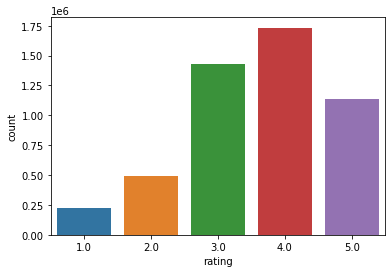

In [8]:
# 평점 분포를 확인해보니
# 4점이 가장 많다
sns.countplot(x=df['rating'])

In [9]:
# 영화 갯수와 사용자 수를 확인해본다
print("Num of movies:", df['movie_id'].nunique())
print("Num of users:", df['user_id'].nunique())

Num of movies: 1000
Num of users: 404555


In [19]:
# 평점을 일정 수준 이하로 받은 영화는 필터링
min_movie_ratings = 100
filter_movies = (df['movie_id'].value_counts() > min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# 평점을 일정 수준 이하로 준 유저는 필터링한다.
min_user_ratings = 50
filter_users = (df['user_id'].value_counts() > min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

df_filterd = df[(df['movie_id'].isin(filter_movies)) & (df['user_id'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('필터링 전 유저 평점 총 수:\t{}'.format(len(df)))
print('필터링 후 유저 평점 총 수:\t{}'.format(len(df_filterd)))

필터링 전 유저 평점 총 수:	5010199
필터링 후 유저 평점 총 수:	1030766


In [20]:
# 학습 데이터와 테스트 데이터로 나눈다.
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_filterd)
del df_filterd

In [21]:
# 평점 데이터를 피봇해서 (유저 수 X 영화 수)의 행렬로 만든다. 원소의 값은 평점 점수가 된다.
# 대부분의 값이 None이므로 sparse 행렬이 된다.
df_p = pd.pivot_table(df_train, index='user_id', columns='movie_id', values='rating')

print(df_p.shape)

(14060, 944)


In [22]:
df_p.head(10)

movie_id,1,10,1000,101,102,103,104,105,106,107,...,990,991,992,993,994,995,996,997,998,999
user_id,,,,,,,,,,,,,,,,,,,,,
1000192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
1000387,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
1000710,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN
1000779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 인기 기반 추천

가장 간단하게 생각할 수 있는 추천 방법은 모든 유저에게 평점 평균이 높은, 즉 인기가 많은 작품을 추천하는 것이다.

In [23]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [24]:
# 가장 평점이 높은 n개의 영화를 뽑는다.
n = 10

# 모든 영화의 평균 평점을 계산한다.
ratings_mean = df_p.mean(axis=0).sort_values(ascending=False).rename('mean rating').to_frame()
ratings_mean.head()

,mean rating
movie_id,
13,4.785714
316,4.188713
753,4.157895
223,4.131560
872,4.131363


In [25]:
# 모든 영화의 평점 개수를 구한다.
ratings_count = df_p.count(axis=0).rename('num of ratings').to_frame()
ratings_count.head()

,num of ratings
movie_id,
1,130
10,56
1000,164
101,72
102,70


In [26]:
# 평균 평점, 평점 개수, 영화 제목을 하나의 데이터프레임으로 합친다.
ratings_with_title = ratings_mean.join(ratings_count).join(df_title.drop('Year', axis=1))
ratings_with_title.head()

,mean rating,num of ratings,Name
movie_id,,,
13,4.785714,14,Lord of the Rings: The Return of the King: Ext...
316,4.188713,567,Futurama: Monster Robot Maniac Fun Collection
753,4.157895,19,Mary Poppins: Bonus Material
223,4.131560,2744,Chappelle's Show: Season 1
872,4.131363,3418,Seven Samurai


In [27]:
# 테스트 데이터에 대해 예측값을 구한다.
df_prediction = df_test.set_index('movie_id').join(ratings_mean)[['rating', 'mean rating']]
df_prediction.head()

,rating,mean rating
movie_id,,
1,3.0,3.461538
1,3.0,3.461538
1,3.0,3.461538
1,3.0,3.461538
1,4.0,3.461538


In [28]:
# RMSE를 계산한다.
y_true = df_prediction['rating']
y_pred = df_prediction['mean rating']
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

print("RMSE of recommendation by popularity:", rmse)

RMSE of recommendation by popularity: 1.0269375481958285


In [29]:
# 가장 평균 평점이 높은 n개 영화를 뽑아 본다.
# 단, 평점 개수가 적을 수록 평점 평균이 왜곡되기 쉽다는 점을 참고하자.
ratings_with_title.head(n)

,mean rating,num of ratings,Name
movie_id,,,
13,4.785714,14,Lord of the Rings: The Return of the King: Ext...
316,4.188713,567,Futurama: Monster Robot Maniac Fun Collection
753,4.157895,19,Mary Poppins: Bonus Material
223,4.131560,2744,Chappelle's Show: Season 1
872,4.131363,3418,Seven Samurai
577,4.130797,841,The Twilight Zone: Vol. 36
752,4.124667,1877,Star Trek: The Next Generation: Season 7
825,4.096557,1336,Bill Cosby: Himself
477,4.090774,672,George Carlin: Personal Favorites


# 상품 중심 협업 필터링으로 비슷한 상품 찾기

평점 데이터를 기반으로 주어진 상품과 비슷한 상품을 찾고, 그 상품들의 평점을 이용해 주어진 상품의 평점을 예측하는 것을 상품 기반 협업 필터링이라고 부른다.

이 실습에서 상품은 영화이다.

In [30]:
# 유저 - 영화 행렬에서 비어 있는 값을 유저의 평균 평점으로 채운다
df_p_imputed = df_p.T.fillna(df_p.mean(axis='columns')).T
df_p_imputed.head()

movie_id,1,10,1000,101,102,103,104,105,106,107,...,990,991,992,993,994,995,996,997,998,999
user_id,,,,,,,,,,,,,,,,,,,,,
1000192,3.206897,3.206897,3.206897,3.206897,3.206897,3.206897,3.206897,3.206897,3.206897,3.206897,...,3.206897,3.206897,3.206897,3.206897,3.206897,3.206897,3.206897,3.206897,3.206897,3.206897
1000301,3.511628,3.511628,3.511628,3.511628,3.511628,3.511628,3.511628,3.511628,3.511628,3.511628,...,3.511628,3.511628,3.511628,3.511628,3.511628,3.511628,2.000000,3.511628,3.511628,3.511628
1000387,3.058824,3.058824,3.058824,3.058824,3.058824,3.058824,3.000000,3.058824,3.058824,3.058824,...,3.058824,3.058824,3.058824,3.058824,3.058824,3.058824,3.058824,3.058824,3.058824,3.058824
1000410,3.255814,3.255814,3.255814,3.255814,3.255814,3.255814,3.255814,3.255814,3.255814,3.255814,...,3.255814,3.255814,3.255814,3.255814,3.255814,3.255814,3.255814,3.255814,3.255814,3.255814
1000527,3.552632,3.552632,3.552632,3.552632,3.552632,3.552632,3.552632,3.552632,3.552632,3.552632,...,3.552632,3.552632,3.552632,3.552632,3.552632,3.552632,3.552632,3.552632,3.552632,3.552632


In [31]:
# 두 영화의 평점 분포가 비슷한지 계산은 코사인 유사도(cosine similarity)로 한다.
# 이를 위해 코사인 유사도 함수를 불러온다.
from sklearn.metrics.pairwise import cosine_similarity

# 유저-영화 행렬을 영화-유저 행렬로 전치(transpose)한다.
df_p_imputed_T = df_p_imputed.T

In [38]:
# 비슷한 n개의 영화를 통해 예측한다.
n_similar_movies = 10

In [39]:
# 모든 영화에 대해 예측하기 전에, 예시로 한 영화에 대해 협업 필터링을 적용해 보자.
movie_id = '13'

# 한 영화의 평점 분포와 다른 모든 영화의 평점 분포를 비교하여 유사도를 구한다.
similarities = cosine_similarity(df_p_imputed_T.loc[[movie_id]], df_p_imputed_T)
similarities = pd.Series(similarities[0], index=df_p_imputed_T.index)
similarities

movie_id
1       0.999561
10      0.999808
1000    0.999399
101     0.999722
102     0.999655
          ...   
995     0.999741
996     0.994550
997     0.999724
998     0.999674
999     0.998719
Length: 944, dtype: float64

In [40]:
# 자기 자신과의 유사도는 1일 수밖에 없다.
similarities[[movie_id]]

# 유사도 목록에서 자기 자신을 제외한다.
similarities.drop(index=movie_id, inplace=True)

# 가장 유사한 n개 영화를 뽑는다.
n_similarities = similarities.sort_values(ascending=False)[:n_similar_movies]
n_similarities

movie_id
196    0.999898
193    0.999896
141    0.999896
874    0.999895
266    0.999893
540    0.999893
176    0.999892
183    0.999891
20     0.999891
716    0.999890
dtype: float64

In [41]:
# 테스트 데이터에서 주어진 movie_id와 관련된 행들을 가져온다. 예측해야 하는 대상이다.
unrated_users = df_test.loc[df_test['movie_id'] == movie_id, 'user_id']
unrated_users

21165     708596
21219      21823
21148    2282493
21188    2480001
21217    2227924
21163     834131
Name: user_id, dtype: object

In [42]:
# 유사 영화에 대해 해당 유저들이 어떻게 평가했는지 가져온다.
n_ratings = df_p_imputed_T.loc[n_similarities.index, unrated_users]
n_ratings

user_id,708596,21823,2282493,2480001,2227924,834131
movie_id,,,,,,
196,4.382979,3.401709,3.761905,2.928571,4.488372,3.526316
193,4.382979,3.401709,3.761905,2.928571,4.488372,3.526316
141,4.382979,3.401709,3.761905,2.928571,4.488372,3.526316
874,4.382979,3.401709,3.761905,2.928571,4.488372,3.526316
266,4.382979,3.401709,3.761905,2.928571,4.488372,3.526316
540,4.382979,3.401709,3.761905,2.928571,5.000000,3.526316
176,4.382979,3.401709,3.761905,2.928571,4.488372,3.526316
183,4.382979,3.401709,3.761905,2.928571,4.488372,3.526316
20,4.382979,3.401709,3.761905,2.928571,4.488372,3.526316


In [43]:
# 각 유저가 다른 영화에 대해 평가한 평점을 유사도를 이용해 가중 평균한다.
weighted_n_ratings = n_ratings.multiply(n_similarities, axis='index')
scores = weighted_n_ratings.sum(axis='index') / n_similarities.sum()
scores

user_id
708596     4.382979
21823      3.401709
2282493    3.761905
2480001    2.928571
2227924    4.539535
834131     3.526316
dtype: float64

In [44]:
# 이렇게 구한 점수가 해당 영화의 예측 평점이 된다.
scores.rename('prediction').reset_index().assign(movie_id = movie_id)

,user_id,prediction,movie_id
0,708596,4.382979,13
1,21823,3.401709,13
2,2282493,3.761905,13
3,2480001,2.928571,13
4,2227924,4.539535,13
5,834131,3.526316,13


In [45]:
# 이제 테스트 데이터의 모든 영화에 돌아가며 같은 과정을 반복해보자.
movie_scores_dfs = []
for movie_id in tqdm(df_test['movie_id'].unique()):
  similarities = cosine_similarity(df_p_imputed_T.loc[[movie_id]], df_p_imputed_T)
  similarities = pd.Series(similarities[0], index=df_p_imputed_T.index)
  similarities.drop(index=movie_id, inplace=True)
  n_similarities = similarities.sort_values(ascending=False)[:n_similar_movies]
  
  unrated_users = df_test.loc[df_test['movie_id'] == movie_id, 'user_id']
  n_ratings = df_p_imputed_T.loc[n_similarities.index, unrated_users]
  weighted_n_ratings = n_ratings.multiply(n_similarities, axis='index')
  scores = weighted_n_ratings.sum(axis='index') / n_similarities.sum()
  scores_df = scores.rename('prediction').reset_index().assign(movie_id = movie_id)
  movie_scores_dfs.append(scores_df)

100%|██████████| 944/944 [02:25<00:00,  6.47it/s]


In [46]:
# 예측한 결과를 하나의 테이블로 합친다.
df_pred_movie = pd.concat(movie_scores_dfs).set_index(['user_id', 'movie_id'])
df_pred_movie = df_test.set_index(['user_id', 'movie_id']).join(df_pred_movie)
df_pred_movie.head()

,,rating,date,prediction
user_id,movie_id,,,
1602339,788,5.0,2004-02-04,3.793651
1556831,171,3.0,2004-08-01,2.115702
1914535,457,4.0,2005-09-25,3.121951
2351276,548,3.0,2001-01-29,2.597015
1272379,831,1.0,2002-01-25,1.819876


In [47]:
# 예측과 정답 레이블을 가져온다.
y_true = df_pred_movie['rating'].values
y_pred = df_pred_movie['prediction'].values

# RMSE를 계산한다.
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

print("RMSE of recommendation by item-item collaborative filtering:", rmse)

RMSE of recommendation by item-item collaborative filtering: 0.9846770959580714


# 유저 중심 협업 필터링으로 비슷한 유저 찾기

위와 동일한 과정을 유저 기반으로도 해보자.

In [48]:
# 비슷한 n개의 유저를 통해 예측한다.
n_similar_users = 10

In [49]:
# 각 유저들을 돌아가며 테스트 데이터의 영화에 대한 평점을 예측한다.
# colab 노트북에서 약 45분이 소모된다.
# 상품 기반에 비해 절대적인 계산량은 같으나 훨씬 시간이 오래 걸린다.
# 그 이유는 유저 수가 영화 수보다 훨씬 많기 때문에, 계산을 조금씩 여러번 해야 하고, 이에 따라 병렬 처리가 어려워지기 때문이다
# 병렬 처리가 속도에 큰 영향을 끼친다는 것을 알 수 있다.
user_scores_dfs = []
for user_id in tqdm(df_test['user_id'].unique()):
  similarities = cosine_similarity(df_p_imputed.loc[[user_id]], df_p_imputed)
  similarities = pd.Series(similarities[0], index=df_p_imputed.index)
  similarities.drop(index=user_id, inplace=True)
  n_similarities = similarities.sort_values(ascending=False)[:n_similar_users]
  
  unrated_movies = df_test.loc[df_test['user_id'] == user_id, 'movie_id']
  n_ratings = df_p_imputed.loc[n_similarities.index, unrated_movies]
  weighted_n_ratings = n_ratings.multiply(n_similarities, axis='index')
  scores = weighted_n_ratings.sum(axis='index') / n_similarities.sum()
  scores_df = scores.rename('prediction').reset_index().assign(user_id = user_id)
  user_scores_dfs.append(scores_df)

100%|██████████| 14060/14060 [43:46<00:00,  5.35it/s]


In [50]:
# 예측한 결과를 하나의 테이블로 합친다.
df_pred_user = pd.concat(user_scores_dfs).set_index(['user_id', 'movie_id'])
df_pred_user = df_test.set_index(['user_id', 'movie_id']).join(df_pred_user)

# 예측과 정답 레이블을 가져온다.
y_true = df_pred_user['rating'].values
y_pred = df_pred_user['prediction'].values

# RMSE를 계산한다.
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

print("RMSE of recommendation by user-user collaborative filtering:", rmse)

RMSE of recommendation by user-user collaborative filtering: 1.2608666744288584
